##Import and Fetch

In [17]:
!pip install pandas_profiling
!pip install category_encoders

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



In [19]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_features.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_labels.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/test_features.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/sample_submission.csv

--2019-07-19 16:55:28--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20054664 (19M) [text/plain]
Saving to: ‘train_features.csv.3’

train_features.csv. 100%[===================>]  19.12M   110MB/s    in 0.2s    

2019-07-19 16:55:29 (110 MB/s) - ‘train_features.csv.3’ saved [20054664/20054664]

--2019-07-19 16:55:29--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP req

In [0]:
import pandas_profiling as pp

In [21]:
!ls

sample_data		 test_features.csv.1   train_features.csv.3
sample_submission.csv	 test_features.csv.2   train_labels.csv
sample_submission.csv.1  test_features.csv.3   train_labels.csv.1
sample_submission.csv.2  train_features.csv    train_labels.csv.2
sample_submission.csv.3  train_features.csv.1  train_labels.csv.3
test_features.csv	 train_features.csv.2


In [0]:
#load dataframes
X = pd.read_csv('train_features.csv')
Y = pd.read_csv('train_labels.csv')

Y = Y.status_group

#Split data
X_train, X_val, y_train, y_val = train_test_split(X, Y,random_state = 42,stratify = Y)
    

In [0]:
#pp.ProfileReport(X)

##Baseline

In [24]:
#Baseline
y_train.value_counts(normalize = True)

functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64

In [25]:
#get nums from df
numericals = X.select_dtypes('number').columns.to_list()
print(numericals)

['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']


In [26]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 350)
model.fit(X_train[numericals],y_train)
model.score(X_val[numericals], y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.5484848484848485

Text(0.5, 1.0, 'non functional')

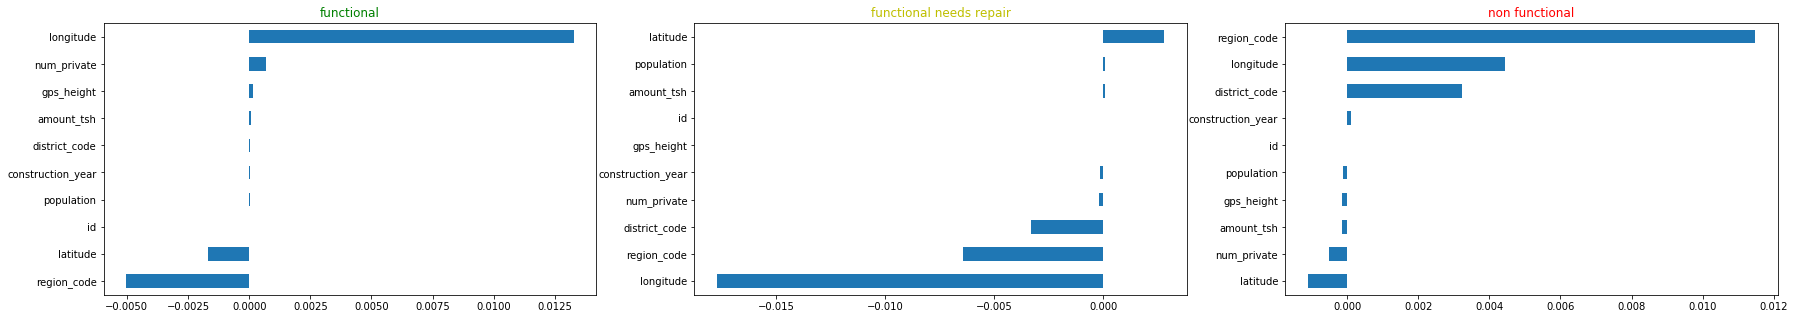

In [59]:
#plot coefficent values for each label
fig = plt.figure(figsize = (30,5), )

ax = fig.add_subplot(131)
coeffs = pd.Series(model.coef_[0], numericals)
ax = coeffs.sort_values().plot.barh()
ax.set_title(model.classes_[0], color = 'g')

ax1 = fig.add_subplot(132)
coeffs = pd.Series(model.coef_[1], numericals)
ax1 = coeffs.sort_values().plot.barh()
ax1.set_title(model.classes_[1], color = 'y')

ax2 = fig.add_subplot(133)
coeffs = pd.Series(model.coef_[2], numericals)
ax2 = coeffs.sort_values().plot.barh()
ax2.set_title(model.classes_[2], color = 'r')


It looks like longitude and region code have some of the largest effects on the model based on the coefficients

##Cleaning


In [0]:
#Clean zeroes, I will infer zero equate to missing data that cant be imputed
zeroes = ['construction_year', 'population', 'longitude']
for col in zeroes:
  X[col].replace(to_replace = 0, value = np.NaN, inplace= True)  

In [68]:
X[zeroes].isnull().sum()

construction_year    20709
population           21381
longitude             1812
dtype: int64

In [0]:
#For consistency, replace latitude values with NaN where longitude contains NaN
X['latitude'] = np.where(X.longitude.isnull(), np.NaN, X.latitude)

In [82]:
X[['latitude', 'longitude']].isnull().sum()

latitude     1812
longitude    1812
dtype: int64

In [125]:
#use median of region to determine nearby elevation and impute missing values

#get region names
regions = X.region.value_counts().index.to_list()

#Get values using medion elevation of the region
values = [X[X.region == region]['gps_height'].median() for region in regions]

#Replace zeroes using median values
#per topographical below 5s and past 35e is closer to sea level(0)
for i in range(len(regions)):
  X[(X.region == regions[i]) & (X.longitude < 35) & (X.latitude > -5) & (X.gps_height == 0)]['gps_height'] = values[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [127]:
X.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
 1290       52
-14         51
 303        51
-18         49
-19         47
 1269       46
 1295       46
 1304       45
-23         45
 280        44
 1538       44
 1286       44
-8          44
-17         44
 1332       43
 320        43
 1317       42
 1293       42
 1319       42
 1359       42
 1264       42
 1288       42
 1401       42
 1303       42
-27         42
         ...  
 2506        1
 2023        1
-53          1
 2364        1
 2332        1
 2402        1
 2236        1
 2420        1
 2291        1
 2407        1
 2080        1
 2250        1
 591         1
 2378        1
 2535        1
 2614        1
 2484        1
 2450        1
 2072        1
 2286        1
 2567        1
 2322        1
 2254        1
 2264        1
 2464        1
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [100]:
X.iloc[29474].longitude

32.82508111

In [0]:
X[(X.latitude < -3) & (X.latitude > -5) & (X.longitude > 31) & (X.longitude < 33)]

In [119]:
X.region.value_counts().index.to_list()

['Iringa',
 'Shinyanga',
 'Mbeya',
 'Kilimanjaro',
 'Morogoro',
 'Arusha',
 'Kagera',
 'Mwanza',
 'Kigoma',
 'Ruvuma',
 'Pwani',
 'Tanga',
 'Dodoma',
 'Singida',
 'Mara',
 'Tabora',
 'Rukwa',
 'Mtwara',
 'Manyara',
 'Lindi',
 'Dar es Salaam']

In [118]:
X[X.region == 'Iringa']['gps_height'].median()

1719.0

In [115]:
X[X.region == 'Iringa']['gps_height'].median()

1719.0